<a href="https://colab.research.google.com/github/stevengregori92/Learn-XGBoost-with-Feature-Importance/blob/main/Diabetes_with_PCA_and_SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install luwiji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 92.6 MB/s eta 0:00:00
  Created wheel for luwiji: filename=luwiji-1.2.1-py2.py3-none-any.whl size=40366830 sha256=ce1e2ea0aefb15dfbb1a7920a846c7a60477fa684bfc697460f73a1f54547540
  Stored in directory: /root/.cache/pip/wheels/ba/90/9e/943ac5067e9cdc185d8f029a1d13278acd52839118acc06c9a
  Created wheel for jcopml: filename=jcopml-1.2.2-py2.py3-none-any.whl size=32178 sha256=24c7418a6b9411605793c050485a4c01fcb9bf8ac2dffe47badb7e6f53d1e3b4
  Stored in directory: /root/.cache/pip/wheels/5e/06/58/749e5f1baf2932285758798a92793d4347888826160b025808
Successfully built luwiji jcopml


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

#Import Dataset

In [3]:
!gdown https://drive.google.com/uc?id=1TTRlv4hv11CvV-CkRXLzoE7Da9LIJTGW

Downloading...
From: https://drive.google.com/uc?id=1TTRlv4hv11CvV-CkRXLzoE7Da9LIJTGW
To: /content/diabetes.zip
100% 9.13k/9.13k [00:00<00:00, 42.5MB/s]


In [4]:
!unzip /content/diabetes.zip

Archive:  /content/diabetes.zip
  inflating: diabetes.csv            


In [5]:
df = pd.read_csv('diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


#Cleaning Dataset

,missing_value,%
Pregnancies,0,0.0
Glucose,0,0.0
BloodPressure,0,0.0
SkinThickness,0,0.0
Insulin,0,0.0
BMI,0,0.0
DiabetesPedigreeFunction,0,0.0
Age,0,0.0
Outcome,0,0.0


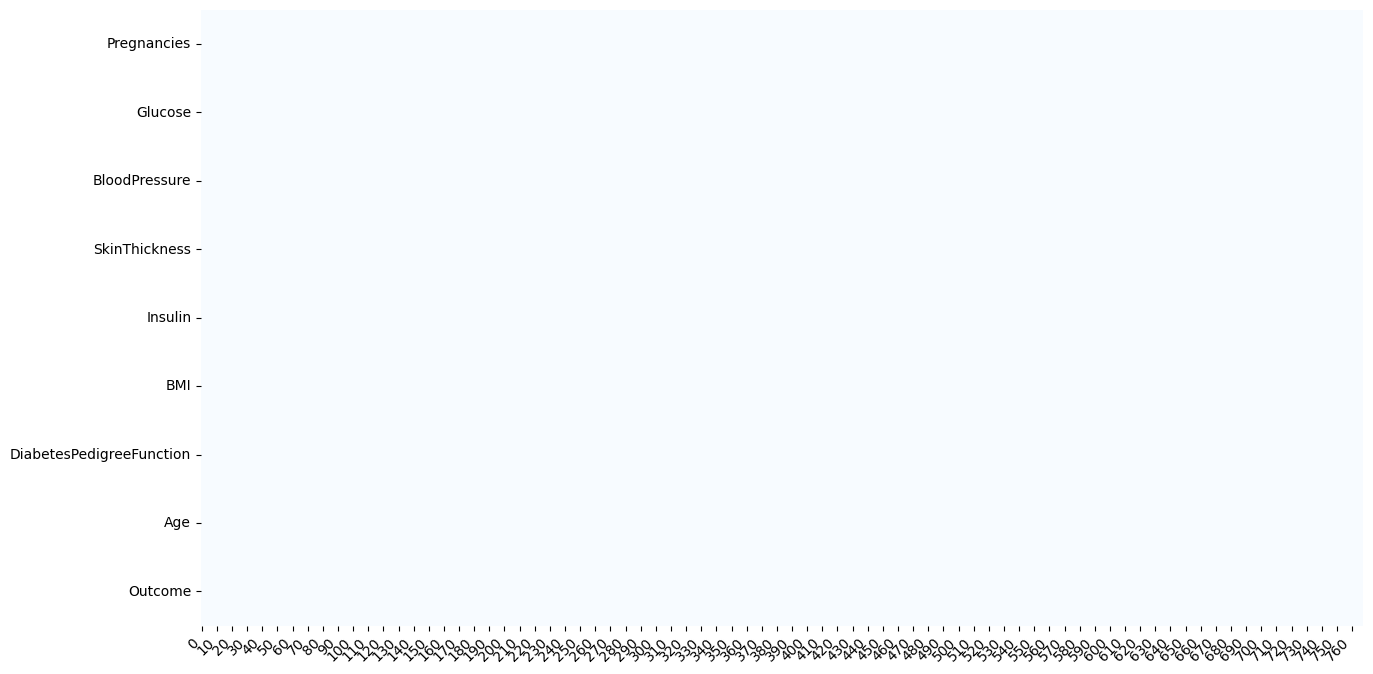

In [6]:
plot_missing_value(df, return_df=True)

#Dataset Splitting

In [7]:
X = df.drop(columns=['Outcome'])
y = df.Outcome

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [8]:
from imblearn.over_sampling import SMOTE

In [9]:
sm = SMOTE(random_state=42,sampling_strategy={0:3505,1:3505})
X_train, y_train = sm.fit_resample(X, y)

/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (3505) in class 0 will be larger than the number of samples in the majority class (class #0 -> 500)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (3505) in class 1 will be larger than the number of samples in the majority class (class #0 -> 500)
  warnings.warn(


#Training

In [10]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [11]:
from sklearn.decomposition import PCA

In [12]:
pca = PCA().fit(X_train)

Text(0, 0.5, 'Cumulative Explained Variance')

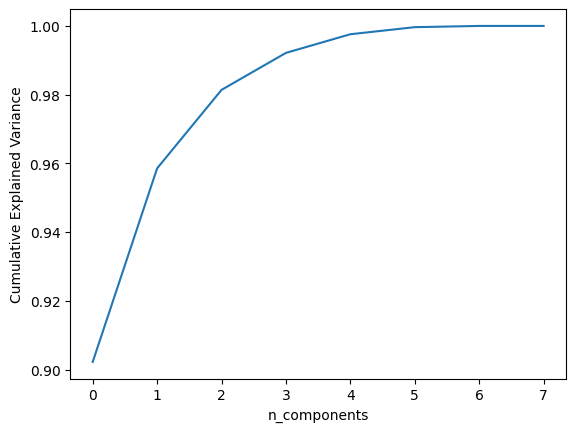

In [13]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('n_components')
plt.ylabel('Cumulative Explained Variance')

In [14]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), X_train.columns)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('pca', PCA(n_components=5, whiten=True)),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter = 50, n_jobs=-1, verbose=1, random_state = 42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.7419203085006956, 'algo__gamma': 1, 'algo__learning_rate': 0.27762530094438326, 'algo__max_depth': 7, 'algo__n_estimators': 113, 'algo__reg_alpha': 0.09444574254983565, 'algo__reg_lambda': 0.12329098365270522, 'algo__subsample': 0.5137705091792748}
0.9965763195435092 0.9229674918865266 1.0


#Confusion Matrix

In [15]:
from jcopml.plot import plot_confusion_matrix

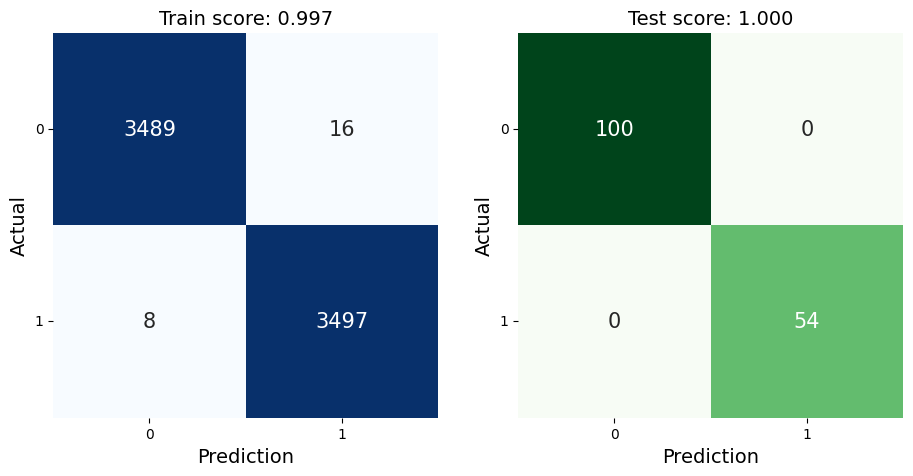

In [16]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)